In [87]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from pylab import *
from utils import *

In [7]:
class AeroplaneEst :

    # Kalmann Filter for estimating the position of the aeroplane

    def __init__(self, init_pos, At, Bt, Ct, Rt, Qt, belief = None):
        if belief is not None:
            self.belief = {'mu' : belief[0], 'sigma' : belief[1]}
        else :
             self.belief = {'mu' : init_pos, 'sigma' : np.zeros((init_pos.shape[0],init_pos.shape[0]))}
        self.state = init_pos
        self.true_state = init_pos
        self.At = At
        self.Bt = Bt
        self.Ct = Ct
        self.Rt = Rt # covariance matrix for the noise in control
        self.Qt = Qt # covariance matrix for the noise in measurement

    def fetchState(self):

        # Fetch the current state of the aeroplane at time t (returns belief distribution)

        return self.state
    
    def updateState(self, u):
         
        self.state = np.matmul(self.At, self.state) + np.matmul(self.Bt, u) + np.random.multivariate_normal(np.zeros(self.Rt.shape[0]),self.Rt)

    def sensor_outputs(self):
        return np.matmul(self.Ct, self.state) + np.random.multivariate_normal(np.zeros(self.Qt.shape[0]),self.Qt)
             
    def predictionUpdate(self, u):
    
            # Prediction update of the state of the aeroplane
            # u is the control input
    
            self.belief['mu'] = np.matmul(self.At, self.belief['mu']) + np.matmul(self.Bt, u) + \
                                np.random.multivariate_normal(np.zeros(self.Rt.shape[0]),self.Rt)
            
            self.belief['sigma'] = np.matmul(self.At, np.matmul(self.belief['sigma'], self.At.T)) + self.Rt
            return self.state

    def measurementUpdate(self, z):
    
            # Measurement update of the state of the aeroplane
            # z is the measurement
    
            Kt = np.matmul(np.matmul(self.belief['sigma'], self.Ct.T), np.linalg.inv(np.matmul(self.Ct, np.matmul(self.belief['sigma'], self.Ct.T)) + self.Qt))
            self.belief['mu'] = self.belief['mu'] + np.matmul(Kt, z - np.matmul(self.Ct, self.belief['mu']))
            self.belief['sigma'] = np.matmul(np.identity(self.belief['sigma'].shape[0]) - np.matmul(Kt, self.Ct), self.belief['sigma'])
            return self.state
    
    def updateBelief(self, u = None, z = None):
            
            # Update the state of the aeroplane at time t
            # u is the control input
            # z is the measurement
            
            if u is not None:
                self.predictionUpdate(u)
            if z is not None:
                self.measurementUpdate(z)
            if u is None and z is None:
                print("No input given")
                
def getIncrement(t = 0):
    return np.array([np.sin(t), np.cos(t), np.sin(t)])


In [24]:
A = np.array([[1,0,0,1,0,0],[0,1,0,0,1,0],[0,0,1,0,0,1],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
B = np.array([[0,0,0],[0,0,0],[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
C = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0]])
rx, ry, rz = 1.2,1.2,1.2 
rvx, rvy, rvz  = 0.01, 0.01, 0.01
Rt = np.diag([rx, ry, rz, rvx, rvy, rvz])**2
Qt = np.eye(3)*(7**2)
mu0 = np.array([0,0,0,0,0,0])
sigma0 = np.eye(6)*((0.01)**2)
simulation_iterations = 500

In [81]:
def simulate(Agent, mu0, sigma0, simulation_iterations = 500, leave_obs_cond = lambda i : i < -1):
    true_state_list = [Agent.state]
    observed_list = [Agent.sensor_outputs()]
    estimated_list = [mu0]
    belief_covariances = [sigma0]
    for i in range(1,simulation_iterations+1):
        Agent.updateState(u = getIncrement(i))

        if leave_obs_cond(i):
            Agent.updateBelief(u = getIncrement(i))
        else:
            Agent.updateBelief(u = getIncrement(i), z = Agent.sensor_outputs())
        
        true_state_list.append(Agent.state)
        observed_list.append(Agent.sensor_outputs())
        estimated_list.append(Agent.belief['mu'])
        belief_covariances.append(Agent.belief['sigma'])
    return true_state_list, observed_list, estimated_list, belief_covariances

In [83]:
Agent = AeroplaneEst(mu0, A, B, C, Rt, Qt)
true_state_list, observed_list, estimated_list, belief_covariances = simulate(Agent, mu0, sigma0, simulation_iterations)

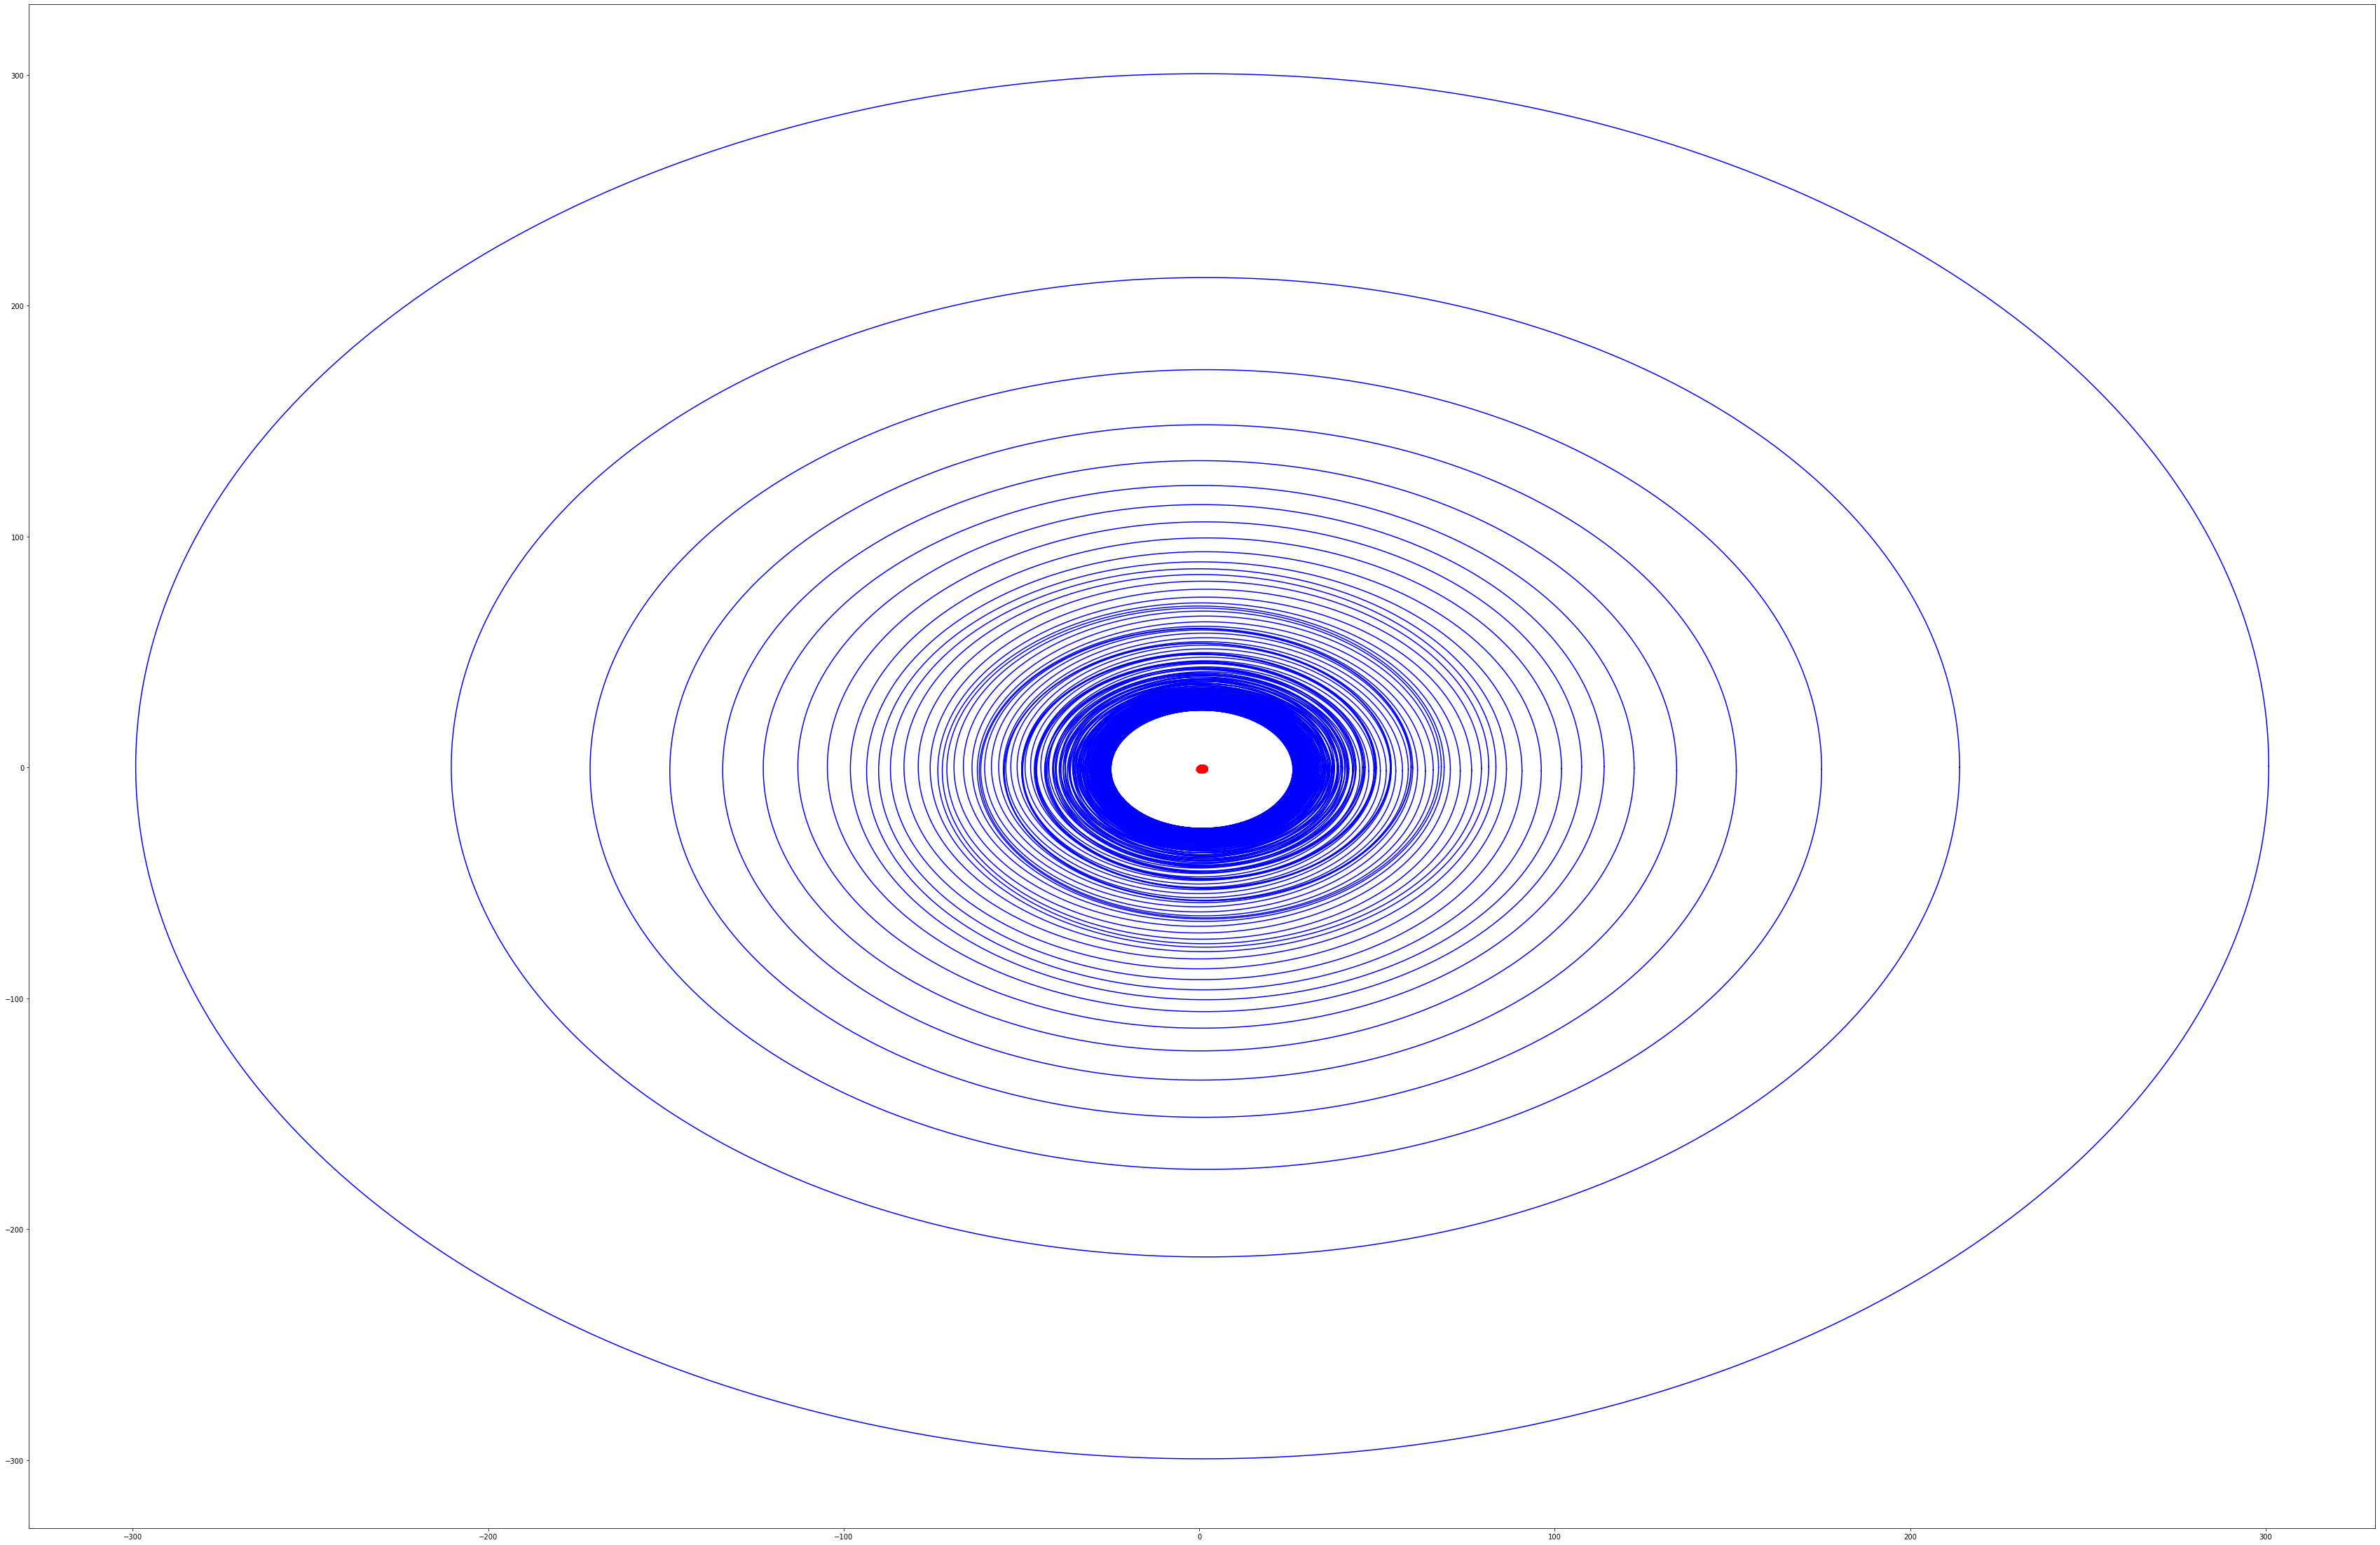

In [88]:
fig, ax = plt.subplots(figsize=(60,40))
ax = uncertainity_ellipse(estimated_list, belief_covariances, ax,3,4)

In [89]:
comb = plot_trajectories([[true_state_list, 'True'], [observed_list, 'Observed'], [estimated_list, 'Estimated']],  0, 1,2)
comb.show()

In [91]:
# plotting actual and observed trajectories
combinedPos = true_state_list + observed_list
true_measured =  ['Actual']*len(true_state_list) + ['Observed']*len(observed_list) 
dataFrame = {'x_column' : [v[0] for v in combinedPos], 'y_column' : [v[1] for v in combinedPos], 'z_column' : [v[2] for v in combinedPos], 'type' : true_measured}
fig = px.line_3d(dataFrame, x='x_column', y='y_column', z='z_column', color='type')
fig.show()
fig.write_html("q1a.html")

In [92]:
combinedPos = true_state_list + observed_list + estimated_list
true_measured =  ['Actual']*len(true_state_list) + ['Observed']*len(observed_list) + ['Estimated']*len(estimated_list)
dataFrame = {'x_column' : [v[0] for v in combinedPos], 'y_column' : [v[1] for v in combinedPos], 'z_column' : [v[2] for v in combinedPos], 'type' : true_measured}
fig = px.line_3d(dataFrame, x='x_column', y='y_column', z='z_column', color='type')
fig.show()
fig.write_html("q1c_trajectory.html")

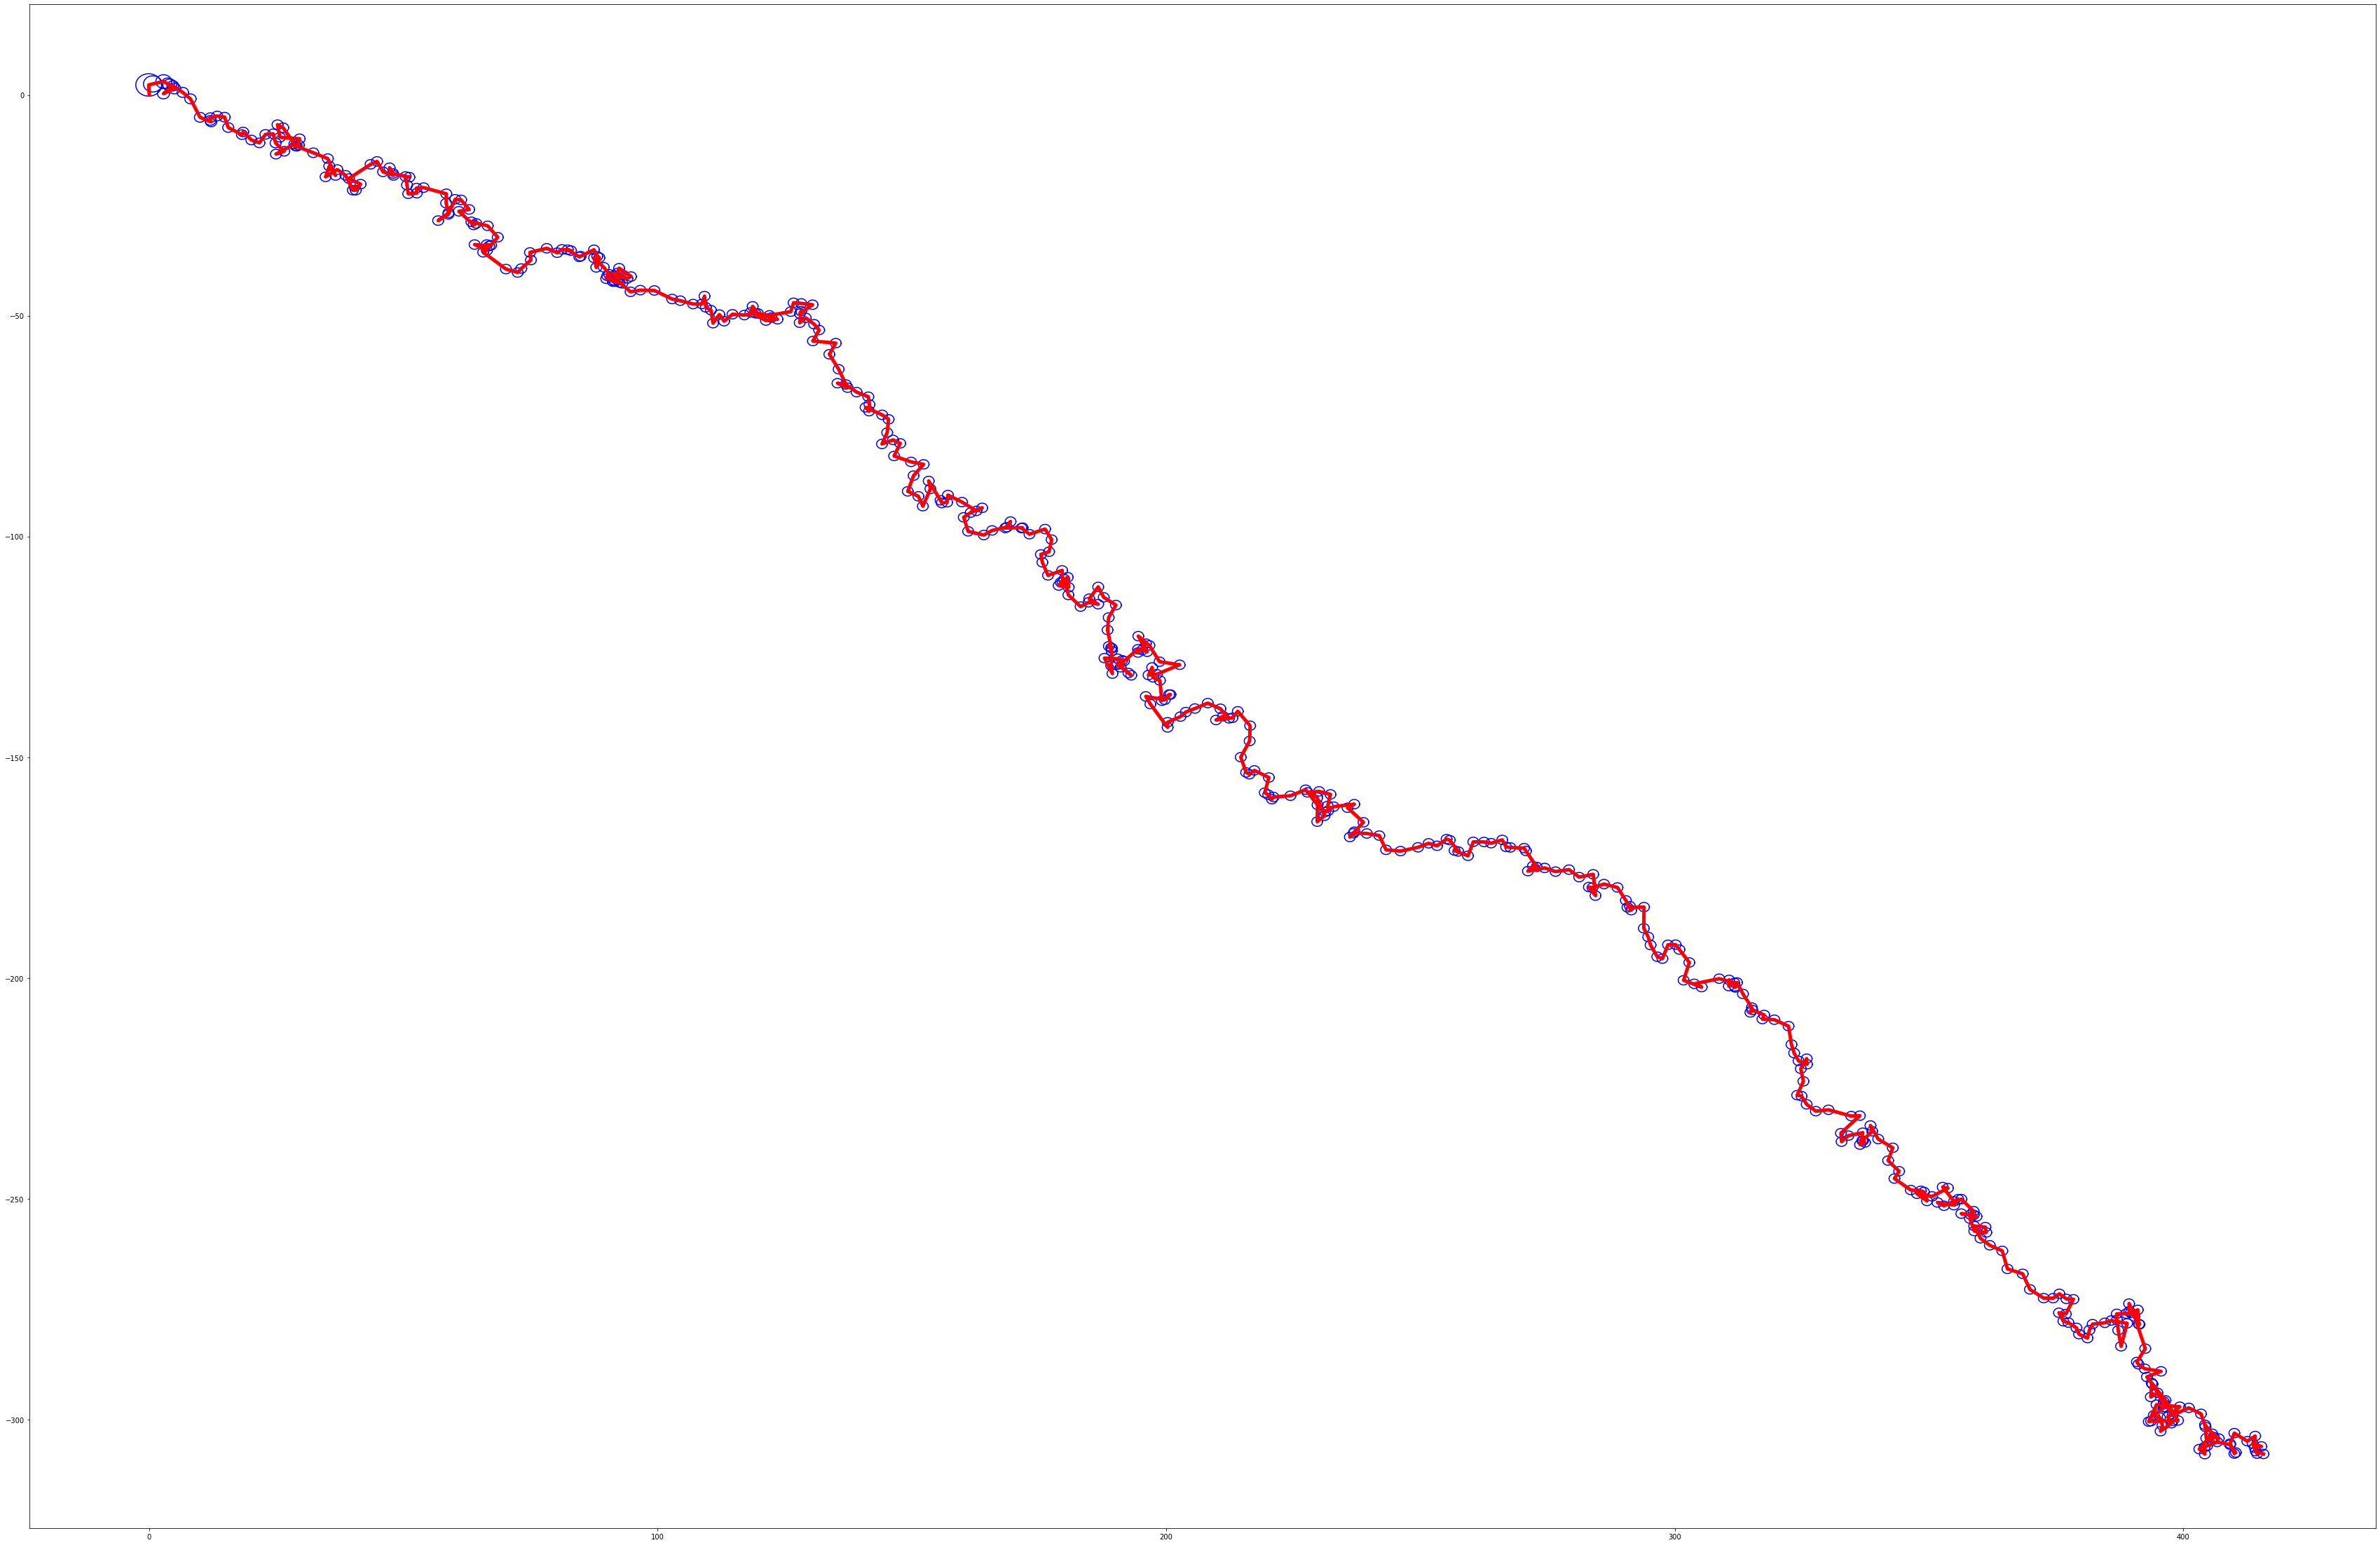

In [93]:
# fig, ax = plt.subplots(figsize=(60,40))
# for i in range(len(belief_covariances)):
#     theta = np.linspace(0, 2 * np.pi, 10000)
#     eigenvalues, eigenvectors = np.linalg.eig(belief_covariances[i][:2,:2])
#     eigenvectors = eigenvectors.T
#     a = np.sqrt(1/eigenvalues[0])
#     b = np.sqrt(1/eigenvalues[1])
#     rotation_angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     if rotation_angle :
#         print(rotation_angle)
#     center = estimated_list[i][:2]
#     ellipse_points = a * np.cos(theta)[:, np.newaxis] * eigenvectors[:, 0] + b * np.sin(theta)[:, np.newaxis] * eigenvectors[:, 1]
#     rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
#     rotated_points = np.dot(rotation_matrix, 6*ellipse_points.T).T
#     rotated_points += center
#     ax.plot(rotated_points[:, 0], rotated_points[:, 1], 'b-')
# estimated_list = np.array(estimated_list)
# ax.plot(estimated_list[:,0], estimated_list[:,1], 'r-', linewidth = 5)
fig, ax = plt.subplots(figsize=(60,40))
ax = uncertainity_ellipse(estimated_list, belief_covariances, ax,0,1)
fig.savefig('q1c_uncertainity.png')

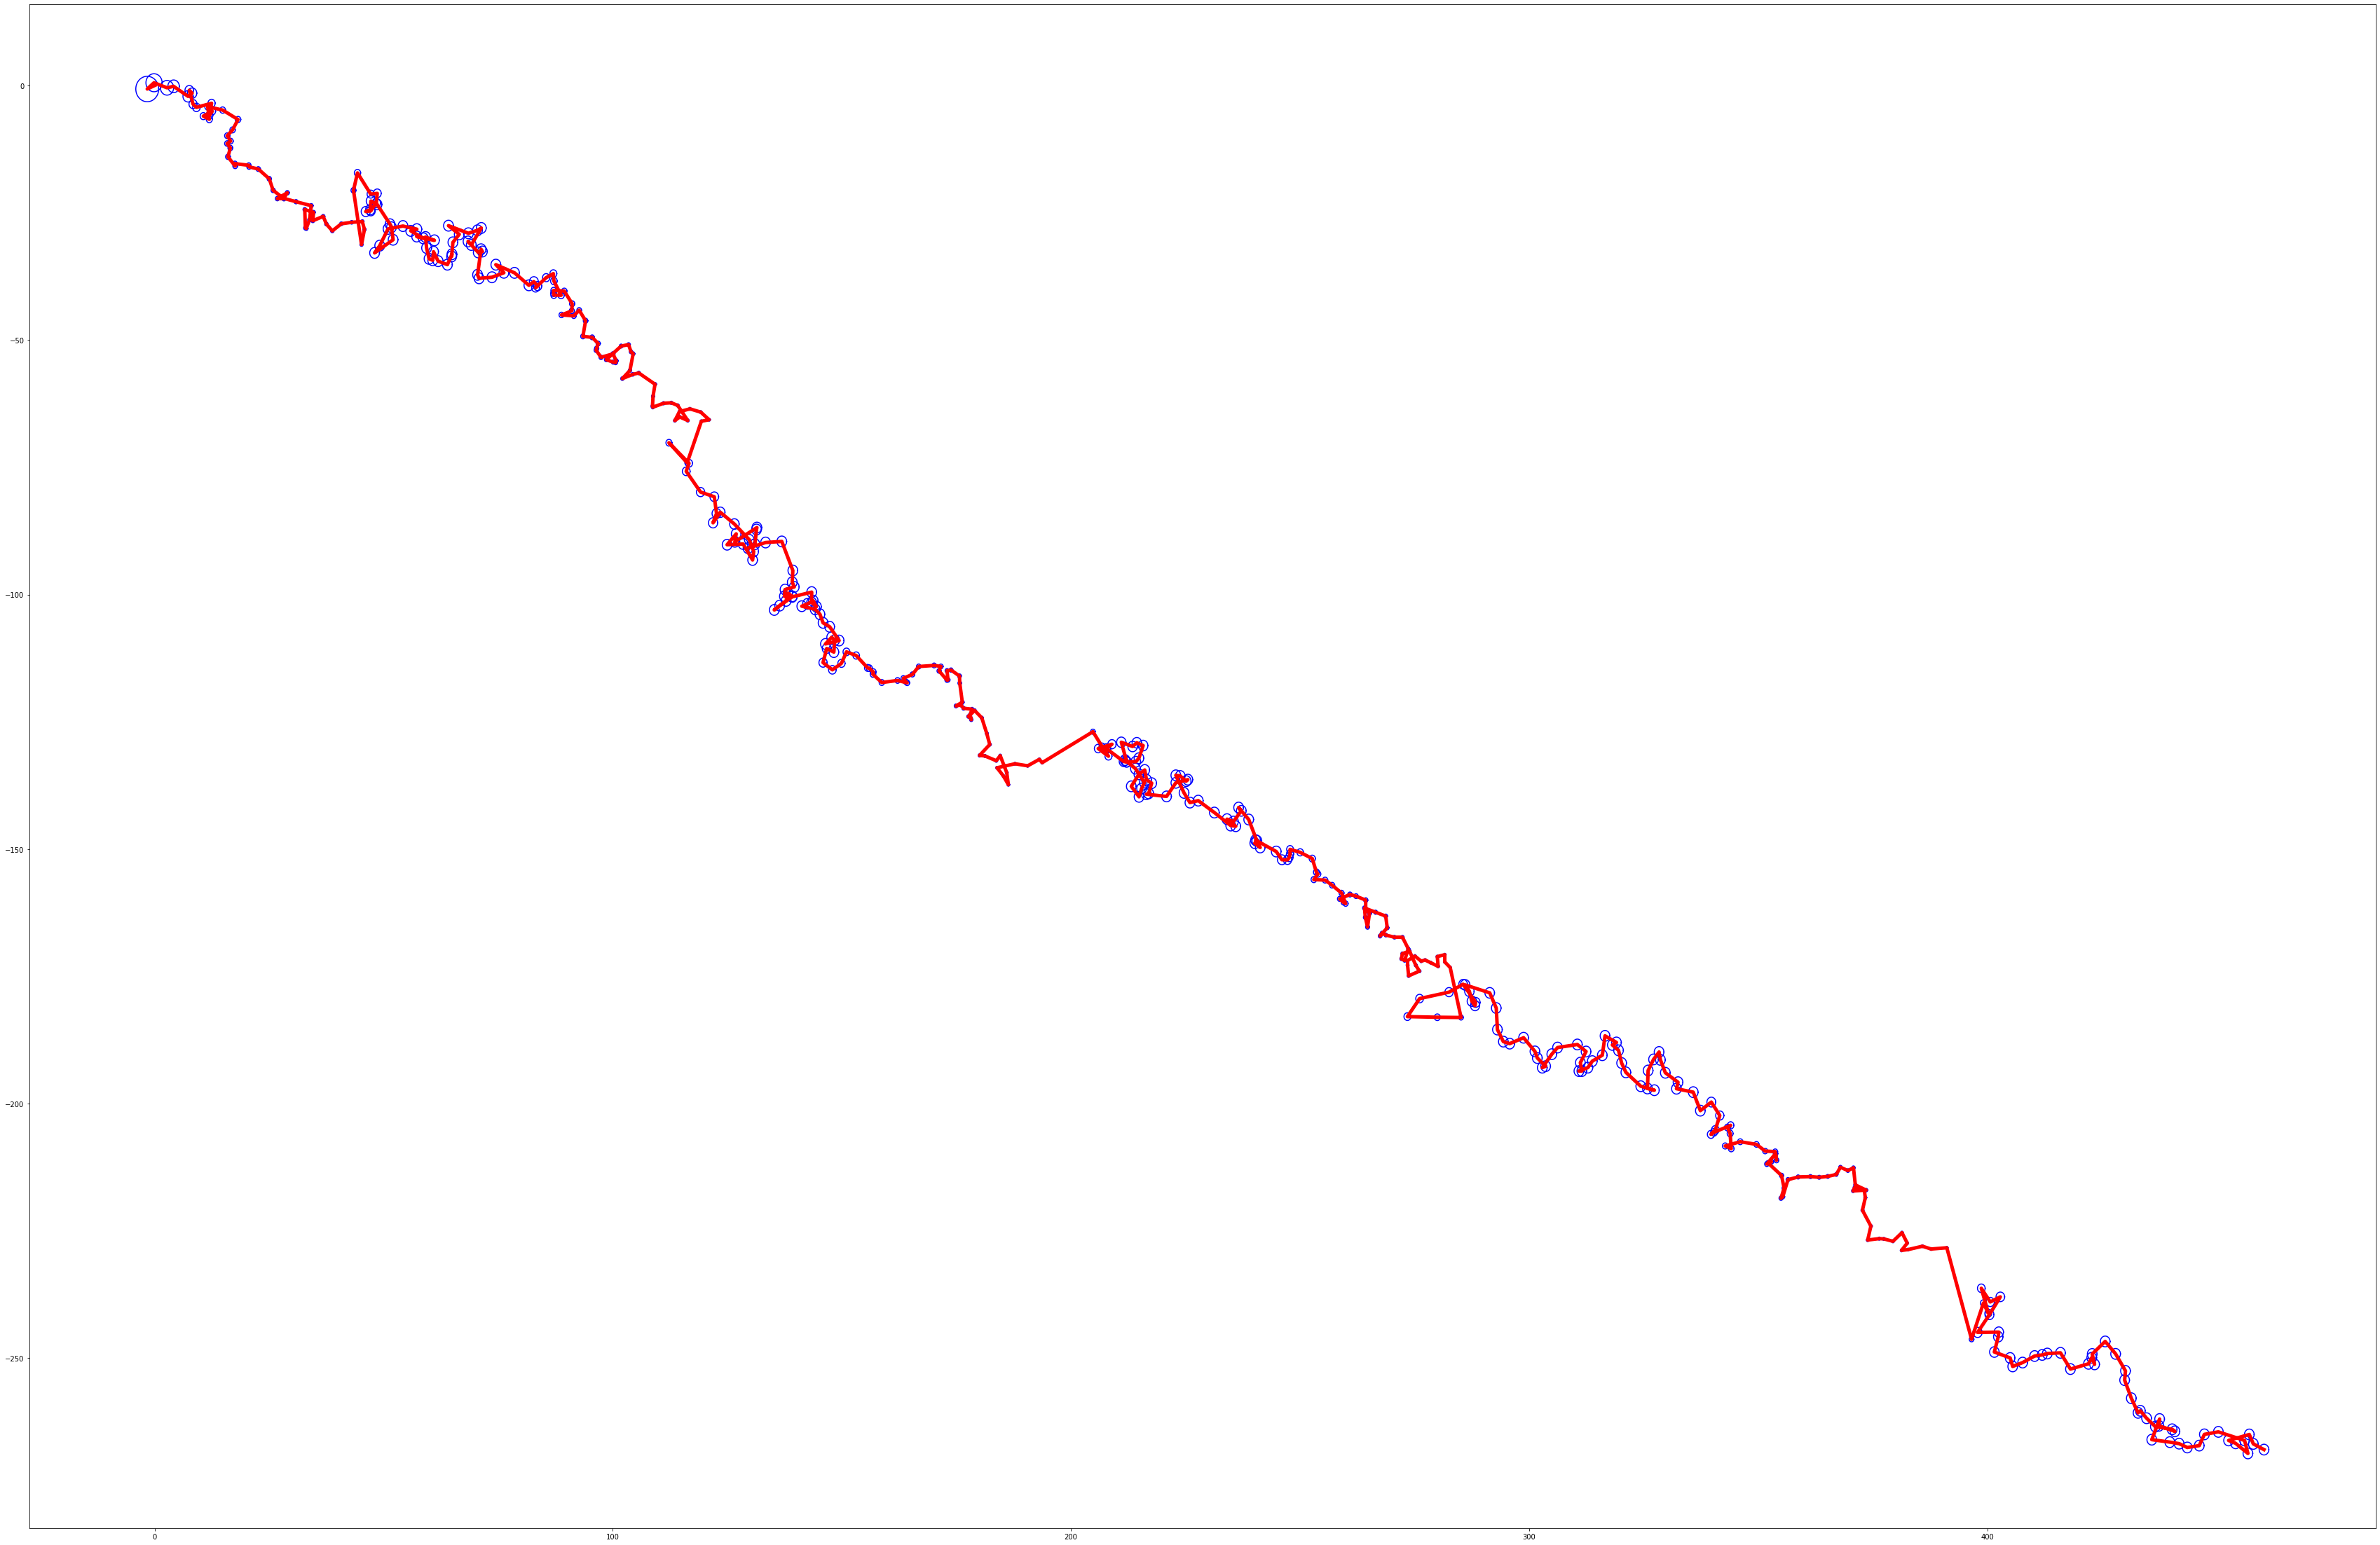

In [96]:
leave_cond = lambda i : 1<=i<=50 or 100<=i<=150 or 200<=i<=250 or 300<=i<=350 or 400<=i<=450
AgentE = AeroplaneEst(mu0, A, B, C, Rt, Qt)
true_state_listE, observed_listE, estimated_listE, belief_covariancesE = simulate(AgentE, mu0, sigma0, simulation_iterations, leave_cond)
traj_e = plot_trajectories([[true_state_listE, 'Actual'], [observed_listE, 'Observed'], [estimated_listE, 'Estimated']],  0, 1,2)
fig_e, ax_e = plt.subplots(figsize=(60,40))
ax_e = uncertainity_ellipse(estimated_listE, belief_covariancesE, ax_e,0,1)
traj_e.write_html("q1e_trajectory.html")
fig_e.savefig('q1e_uncertainity.png')
# fig_e.show()
# traj_e.show()

In [98]:
traj_vel_f = plot_trajectories([[true_state_list, 'Actual'], [estimated_list, 'Estimated']],  3, 4,5)
traj_vel_f.write_html("q1f_trajectory.html")
traj_vel_f.show()

In [79]:
#mean square error of velocities
np.sqrt(np.mean(np.square(np.linalg.norm(np.array(true_state_list)[:,3:] - np.array(estimated_list)[:,3:],axis = 1))))

0.2342693793552474

In [80]:
#mean square error of positions
np.sqrt(np.mean(np.square(np.linalg.norm(np.array(true_state_list)[:,:3] - np.array(estimated_list)[:,:3],axis = 1))))

11.671569591410236

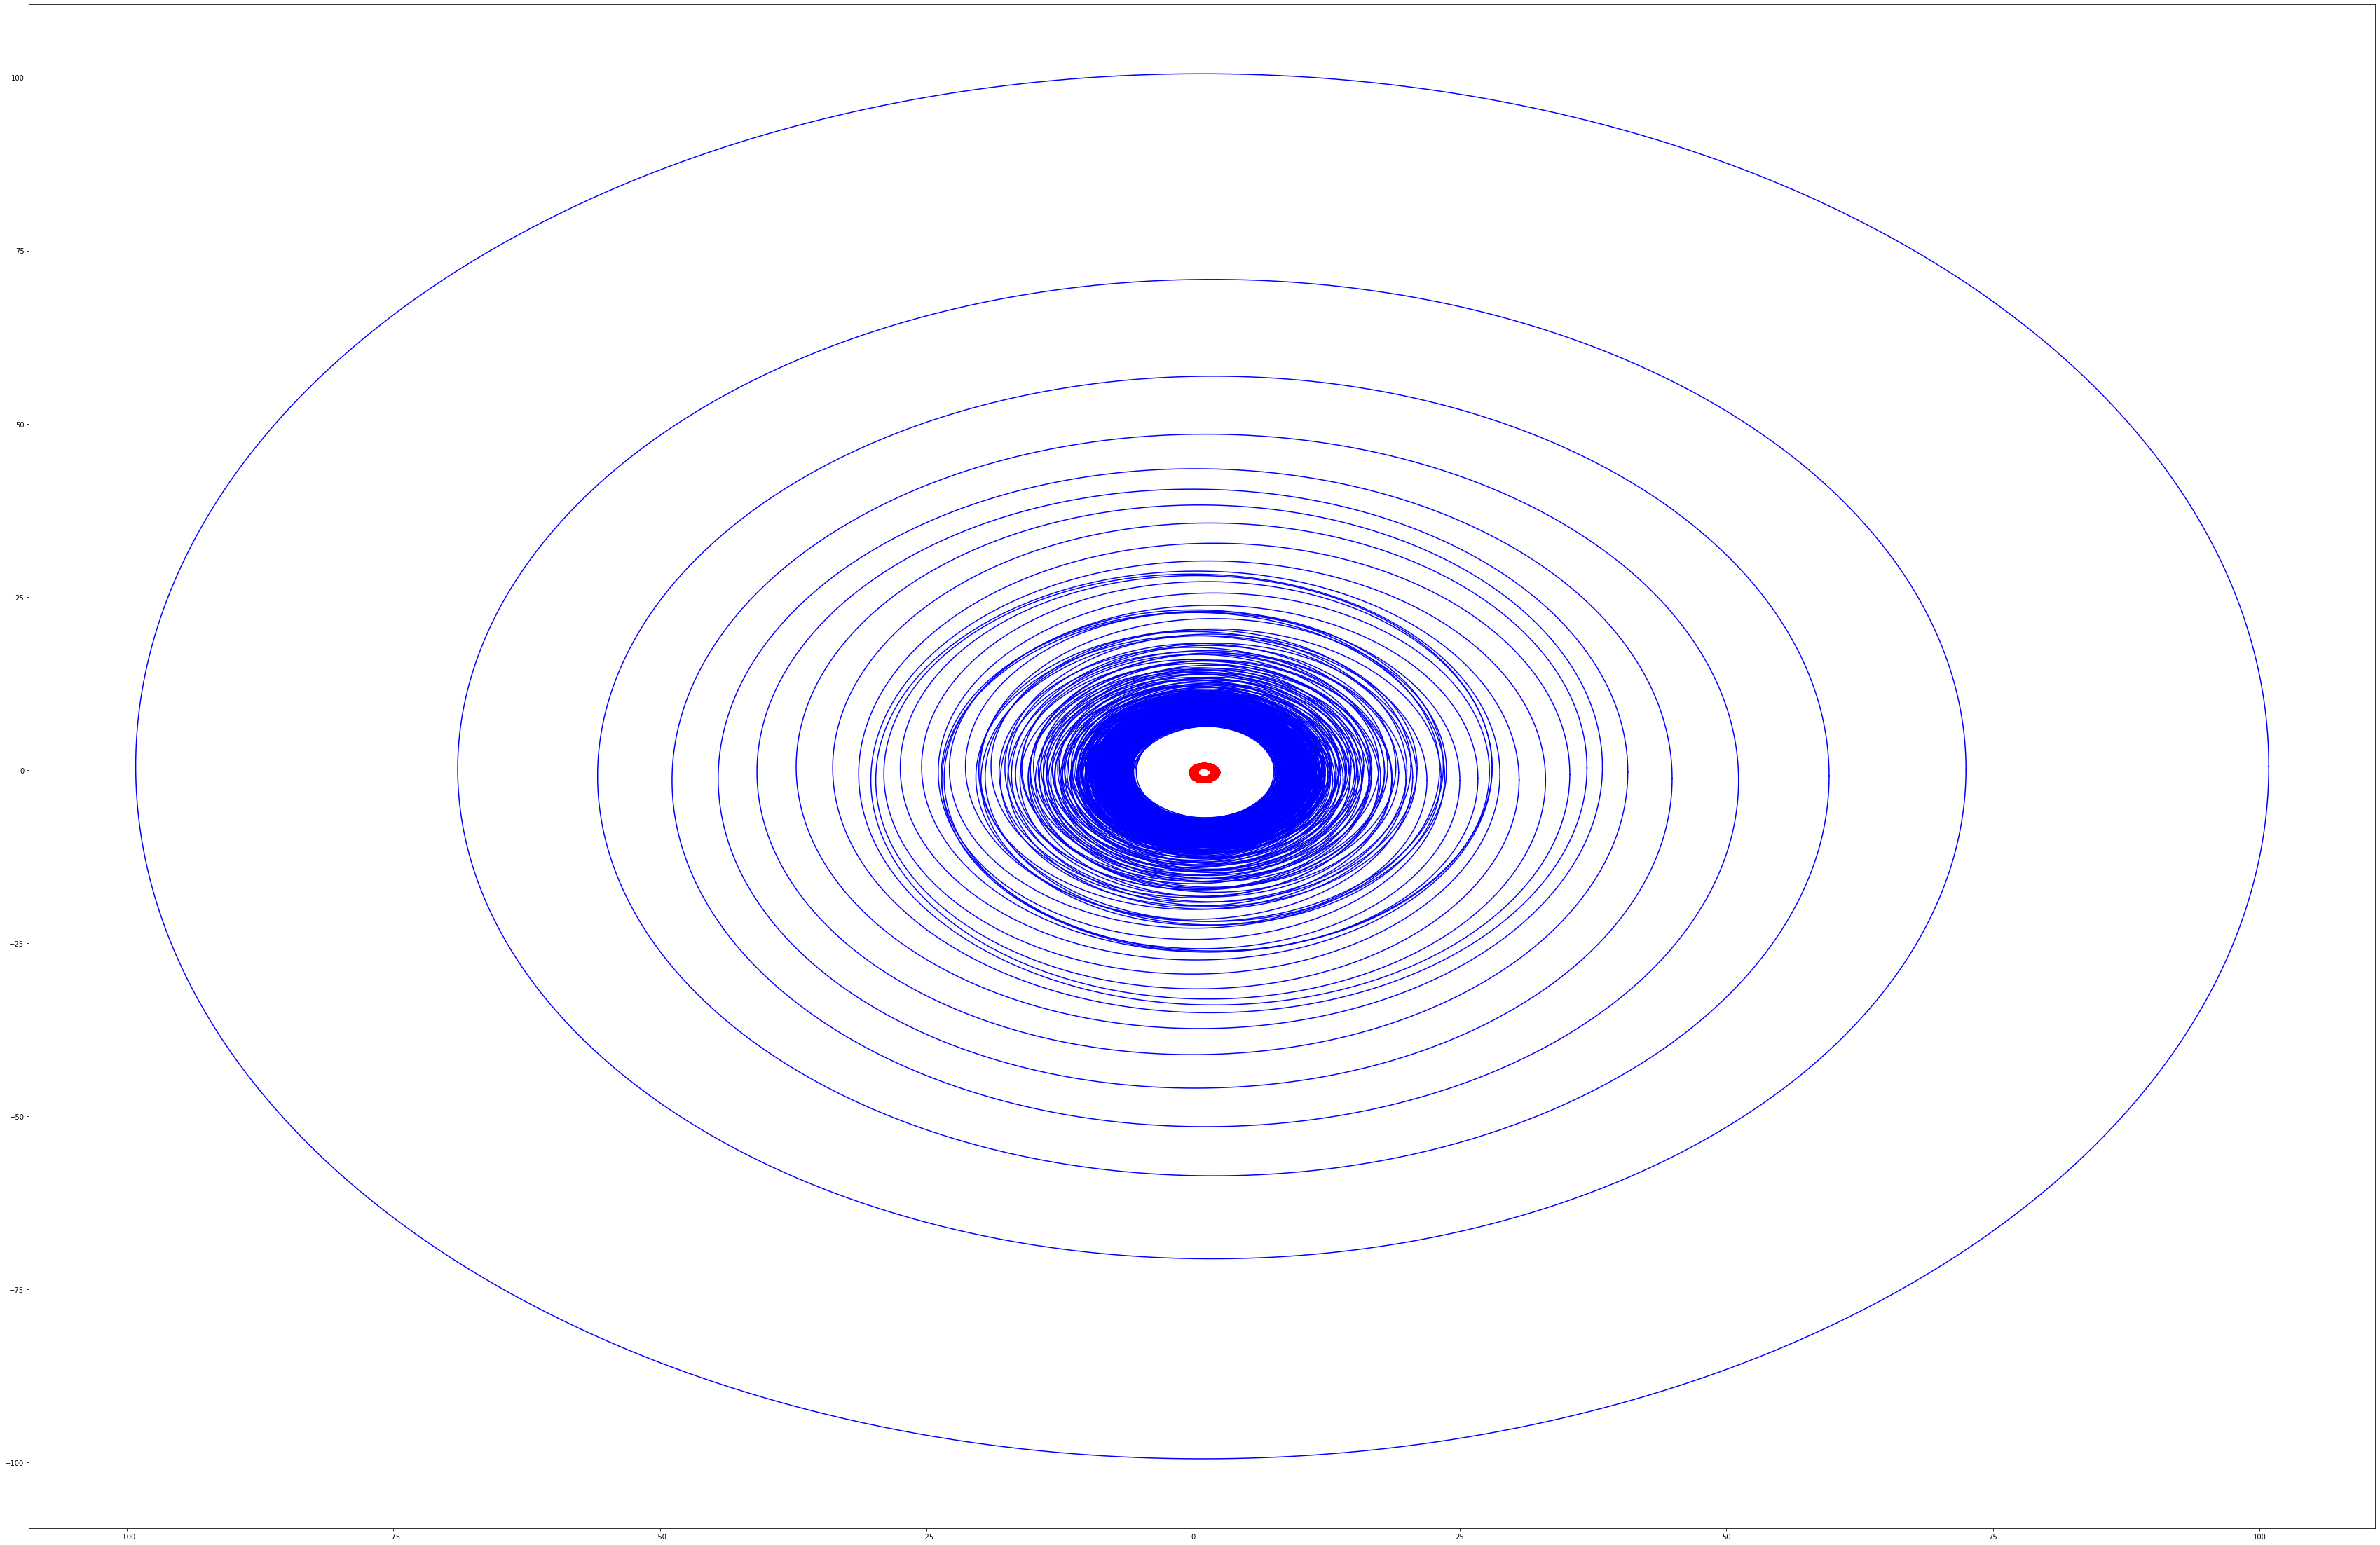

In [96]:
fig, ax = plt.subplots(figsize=(60,40))
for i in range(len(belief_covariances)):
    theta = np.linspace(0, 2 * np.pi, 10000)
    eigenvalues, eigenvectors = np.linalg.eig(belief_covariances[i][3:5,3:5])
    eigenvectors = eigenvectors.T
    a = np.sqrt(1/eigenvalues[0])
    b = np.sqrt(1/eigenvalues[1])
    rotation_angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    if rotation_angle :
        print(rotation_angle)
    center = estimated_list[i][3:5]
    ellipse_points = a * np.cos(theta)[:, np.newaxis] * eigenvectors[:, 0] + b * np.sin(theta)[:, np.newaxis] * eigenvectors[:, 1]
    rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
    rotated_points = np.dot(rotation_matrix, ellipse_points.T).T
    rotated_points += center
    ax.plot(rotated_points[:, 0], rotated_points[:, 1], 'b-')
    ax.scatter(center[0], center[1], c = 'r')
estimated_list = np.array(estimated_list)
ax.plot(estimated_list[:,3], estimated_list[:,4], 'r-', linewidth = 5)
fig.savefig('q1f_uncertainity.png')

In [93]:
estimated_list[0][3:5]

array([0.84954909, 0.53451477])